## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


# from sklearn.linear_model import LogisticRegression #dont need
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

from src.utils.pandas_extensions import one_hot_encoding

## Functions

In [ ]:
def clean_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    print(dataframe.info())
    processed_data = dataframe.dropna().copy()
    processed_data = one_hot_encoding(processed_data, "Subscription Type")
    processed_data.loc[processed_data["Support Calls"] == "none"] = 0
    # processed_data = processed_data["Support Calls"].astype("int")

    return processed_data

In [ ]:
def one_hot_encoding(dataframe: pd.DataFrame, column: str) -> pd.DataFrame:
    if (column not in dataframe.columns):
        raise AssertionError(f"Column {column} doesn't exist")
    
    nparr = dataframe[column].value_counts()
    
    for new_col in nparr.index:
        new_series = dataframe[column] == new_col
        dataframe[f"{column}_{new_col}"] = new_series

    return dataframe

## Load data

In [198]:
unprocessed_data = pd.read_csv("../data/raw/train.csv")

In [230]:
np.random.seed(311)
processed_data = clean_data(unprocessed_data)
X = processed_data[["Age", "Gender", "Tenure", "Usage Frequency", "Support Calls", "Customer Status", "Last Interaction", "Payment Delay", "Subscription Type_Premium", "Subscription Type_Basic", "Subscription Type_Standard"]]
y = processed_data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303124 entries, 0 to 303123
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         303124 non-null  int64  
 1   Age                303124 non-null  int64  
 2   Gender             303124 non-null  object 
 3   Tenure             241103 non-null  float64
 4   Usage Frequency    303124 non-null  int64  
 5   Support Calls      240704 non-null  object 
 6   Payment Delay      214800 non-null  float64
 7   Subscription Type  303124 non-null  object 
 8   Contract Length    303124 non-null  object 
 9   Total Spend        303124 non-null  float64
 10  Last Interaction   240574 non-null  float64
 11  Customer Status    303124 non-null  object 
 12  Last Due Date      303124 non-null  object 
 13  Last Payment Date  303124 non-null  object 
 14  Churn              303124 non-null  int64  
dtypes: float64(4), int64(4), object(7)
memory usage: 34

C:\Users\Scott\AppData\Local\Temp\ipykernel_23556\3561732101.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  processed_data.loc[processed_data["Support Calls"] == "none"] = 0
C:\Users\Scott\AppData\Local\Temp\ipykernel_23556\3561732101.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  processed_data.loc[processed_data["Support Calls"] == "none"] = 0
C:\Users\Scott\AppData\Local\Temp\ipykernel_23556\3561732101.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  process

KeyError: "None of [Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',\n       'Customer Status', 'Last Interaction', 'Payment Delay',\n       'Subscription Type_Premium', 'Subscription Type_Basic',\n       'Subscription Type_Standard'],\n      dtype='object')] are in the [index]"

In [213]:
# print(unprocessed_data.head(n=20))
processed_data.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Customer Status,Last Due Date,Last Payment Date,Churn,Subscription Type_Premium,Subscription Type_Standard,Subscription Type_Basic
3,130847,24,Male,39.0,21,2,14.0,Standard,Quarterly,775.00,18.0,active,06-30,07-14,0,False,True,False
12,468959,30,Male,54.0,13,3,0.0,Basic,Quarterly,522.78,19.0,active,06-18,06-18,0,False,False,True
15,466346,43,Female,11.0,24,none,15.0,Premium,Quarterly,566.46,11.0,active,06-28,07-13,0,True,False,False
20,187564,40,Male,14.0,3,none,2.0,Basic,Quarterly,198.00,20.0,active,06-08,06-10,0,False,False,True
22,304125,61,Female,25.0,14,2,2.0,Premium,Monthly,427.00,13.0,active,06-22,06-24,0,True,False,False


In [214]:
#try ph with depth 1, ph with depth 4, ph with depth None
#try N as the features with the same depth value
#try cycle through the rest of the fa
# features = ["Usage Frequency", "Age", "Support Calls", "Last Interaction", "Payment Delay", "Subscription Type_Premium", "Subscription Type_Basic", "Subscription Type_Standard"]
features = ["Usage Frequency", "Age", "Subscription Type_Premium", "Subscription Type_Basic", "Subscription Type_Standard"]
depth_limit = 16
model = DecisionTreeClassifier(criterion='entropy', max_depth=depth_limit)
model.fit(X_train[features], y_train)

#Predict on train data
y_pred_train = model.predict(X_train[features])

#Predict on test data
y_pred_test = model.predict(X_test[features])

train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
train_f1_score = metrics.f1_score(y_train, y_pred_train)
testing_accuracy = metrics.accuracy_score(y_test, y_pred_test)
testing_f1_score = metrics.f1_score(y_test, y_pred_test)

print("---------Training performance---------")
print(f"{train_accuracy=}")
print(f"{train_f1_score=}")
print("---------Testing performance---------")
print(f"{testing_accuracy=}")
print(f"{testing_f1_score=}")

---------Training performance---------
train_accuracy=0.9886259572378462
train_f1_score=0.08342245989304813
---------Testing performance---------
testing_accuracy=0.9872104546017589
testing_f1_score=0.037296037296037296


Text(0.5, 1.0, "Descision Tree (features=['Usage Frequency', 'Age', 'Subscription Type_Premium', 'Subscription Type_Basic', 'Subscription Type_Standard'], depth_limit=16)")

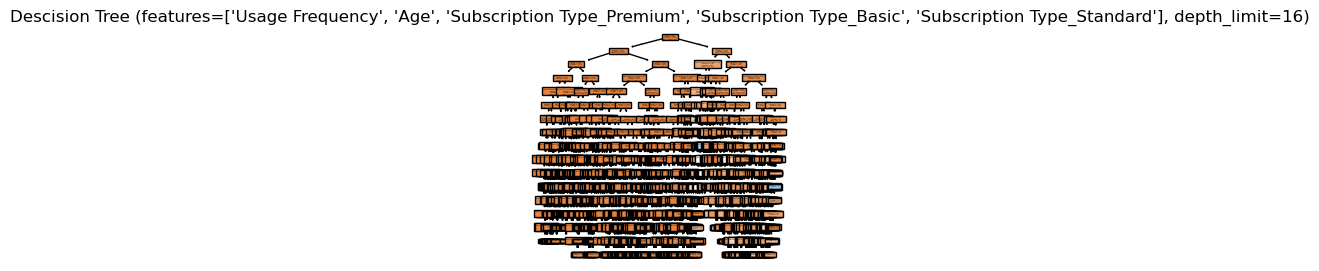

In [215]:
plt.figure(figsize=(3,3))
plot_tree(model, feature_names=features, filled=True)
plt.title(f"Descision Tree ({features=}, {depth_limit=})")

## Export

In [219]:
test_data = pd.read_csv("../data/raw/test.csv")
test_data = clean_data(test_data)
# test_data = test_data.replace("none", 0)
test_pred = model.predict(test_data[features])
test_data.value_counts()

C:\Users\Scott\AppData\Local\Temp\ipykernel_23556\624353438.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  processed_data.loc[processed_data["Support Calls"] == "none"] = 0
C:\Users\Scott\AppData\Local\Temp\ipykernel_23556\624353438.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  processed_data.loc[processed_data["Support Calls"] == "none"] = 0
C:\Users\Scott\AppData\Local\Temp\ipykernel_23556\624353438.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  processed_

CustomerID  Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  Subscription Type  Contract Length  Total Spend  Last Interaction  Last Due Date  Last Payment Date  Customer Status  Subscription Type_Premium  Subscription Type_Standard  Subscription Type_Basic
0           0    0       0.0     0                0              0              0                  0                0.00         0.0               0              0                  0                False                      False                       False                      6266
337117      22   Female  4.0     15               7              18             Standard           Quarterly        339.00       21.0              06-29          07-17              active           False                      True                        False                         1
337030      30   Female  17.0    15               5              10             Standard           Monthly          968.00       4.0               06-16 

In [221]:
export = test_data[["CustomerID"]]
export["Churn"] = test_pred

date = datetime.now()
export.to_csv("../data/processed/export" + str(date).replace(":", "") + ".csv", index=False)

C:\Users\Scott\AppData\Local\Temp\ipykernel_23556\1555304509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export["Churn"] = test_pred
